# Рынок заведений общественного питания Москвы

## Описание данных

Мы решили открыть небольшое кафе в Москве, где гостей должны обслуживать роботы. Необходимо исследовать текущее положение дел на рынке и показать потенциальным инвесторам, сможет ли такое кафе снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

У нас есть открытые данные о заведениях общественного питания в Москве - таблица rest_data:
- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

## Загрузка данных и их подготовка

Импорт библиотек и настройки:

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
from io import BytesIO
import requests
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 180)

Сохранение данных о заведениях общественного питания в переменные. Просмотр информации о датафрейме и вывод на экран нескольких строк из таблицы для ознакомления с данными.

In [2]:
rest_data = pd.read_csv('/datasets/rest_data.csv')
rest_data.info()
rest_data.sample(n=10, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
2973,22736,Луна,нет,кафе,"город Москва, Михалковская улица, дом 38, строение 6",40
2593,29065,Столовая ГБОУ 45 Гимназия имени Л.И. Мильграмма,нет,столовая,"город Москва, улица Гримау, дом 8",300
6737,23349,Столовая ГБОУ СОШ № 1900,нет,столовая,"город Москва, Дубравная улица, дом 41, корпус 4",240
14940,222539,Holy Vegan,нет,кафе,"город Москва, Ходынский бульвар, дом 4",0
4088,26585,Ресторан «Очаг гурманов»,нет,ресторан,"город Москва, Каширское шоссе, дом 51, корпус 3",42
5910,28867,школа 775,нет,буфет,"город Москва, Армавирская улица, дом 4",210
10541,187743,24 Градуса,нет,бар,"город Москва, Митинская улица, дом 36",4
14563,217236,Чайхана ОШ,нет,ресторан,"город Москва, проспект Андропова, дом 36",49
10497,182718,ABC Coffee Roasters,нет,кафе,"город Москва, улица Покровка, дом 7/9-11, корпус 1",15
7708,111069,Кафе Иль Патио «Il Patio»,да,кафе,"город Москва, Каширское шоссе, дом 26",176


Проверка датафрейма на наличие дубликатов:

In [3]:
print('Количество дубликатов в датафрейме:', rest_data.duplicated().sum())

Количество дубликатов в датафрейме: 0


**Вывод**

Из выведенной информации видно, что в таблице нет пропущенных значений, а типы данных столбцов соответствуют содержащейся в них информации. Кроме того, была проведена проверка на наличие дубликатов - дубликаты обнаружены не были. Таким образом мы подготовили датафрейм для дальнейшей работы.

## Анализ данных

### Исследование видов объектов общественного питания

Посмотрим количество объектов общественного питания по каждому виду:

In [4]:
(rest_data['object_type']
     .value_counts()
     .reset_index()
     .rename(columns={'index': 'Вид объекта общественного питания', 'object_type': 'Количество'})
)

,Вид объекта общественного питания,Количество
0,кафе,6099
1,столовая,2587
2,ресторан,2285
3,предприятие быстрого обслуживания,1923
4,бар,856
5,буфет,585
6,кафетерий,398
7,закусочная,360
8,магазин (отдел кулинарии),273


Построим графики, чтобы визуализировать соотношение видов объектов общественного питания:

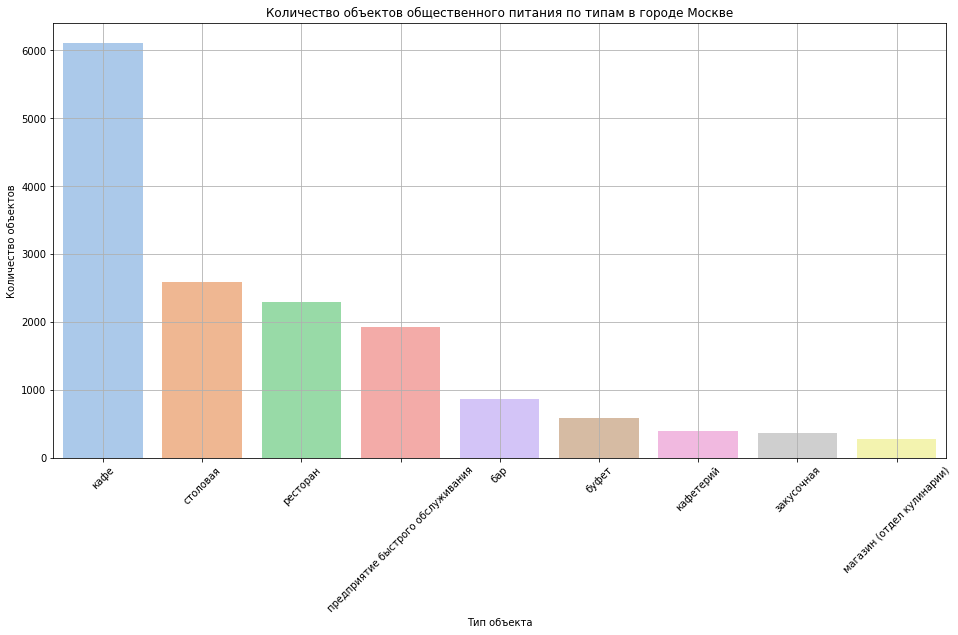

In [5]:
plt.figure(figsize=(16, 8))
sns.set_palette('pastel')
sns.barplot(x='index', y='object_type', data=rest_data['object_type'].value_counts().reset_index())
plt.title('Количество объектов общественного питания по типам в городе Москве')
plt.xlabel('Тип объекта')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)
plt.grid()

Большинство объектов общественного питания в Москве - это кафе. Второе место с большим отрывом в более чем 2 раза занимают столовые, на третьем с немного меньшим количеством по сравнению со столовыми - рестораны. Ресторанам немного уступают по количеству предприятия быстрого питания. Первую пятёрку завершают бары - однако их уже в 2 раза меньше, чем предприятий быстрого питания.

Построим круговую диаграмму соотношения видов объектов общественного питания и оценим его в процентах.

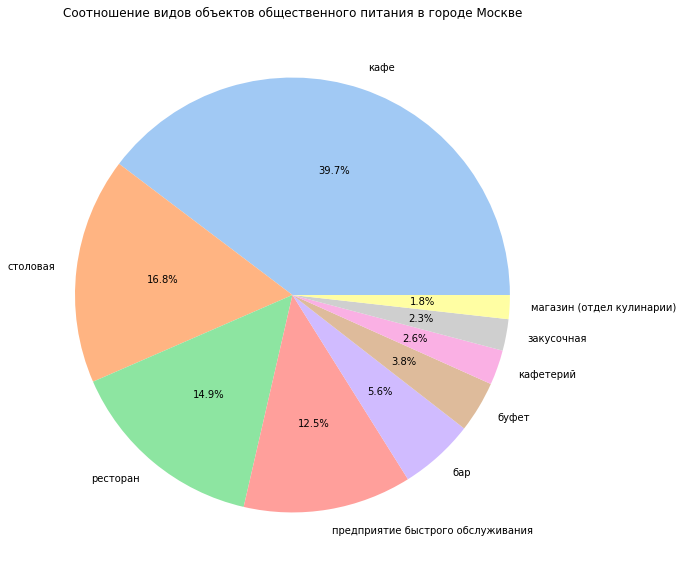

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(rest_data['object_type'].value_counts().reset_index()['object_type'], labels=rest_data['object_type'].value_counts().reset_index()['index'], autopct='%1.1f%%')
plt.title('Соотношение видов объектов общественного питания в городе Москве')
plt.show()

Самым распространённым типом заведений, как уже было замечено, является кафе - на его долю приходится почти 40% всех объектов общественного питания. На втором месте - столовые (16.8%), на третьем - рестораны (14.9%). К предприятиям быстрого питания относится 12.5% заведений, а к барам - 5.6%. На остальные типы (буфет, кафетерий, закусочная, отдел кулинарии в магазинах) приходится лишь примерно 10% от общего количества.

Посмотрим теперь, как соотносится количество сетевых и несетевых заведений по количеству. Построим график.

In [7]:
(rest_data['chain']
     .value_counts()
     .reset_index()
     .rename(columns={'index': 'Является ли заведение сетевым', 'chain': 'Количество'})
)

,Является ли заведение сетевым,Количество
0,нет,12398
1,да,2968


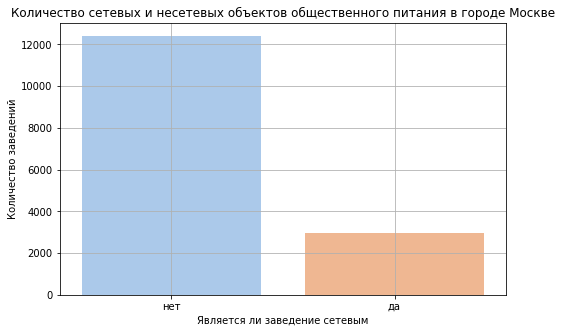

In [8]:
plt.figure(figsize=(8, 5))
sns.barplot(x='index', y='chain', data=rest_data['chain'].value_counts().reset_index())
plt.title('Количество сетевых и несетевых объектов общественного питания в городе Москве')
plt.xlabel('Является ли заведение сетевым')
plt.ylabel('Количество заведений')
plt.xticks(rotation=0)
plt.grid()
plt.show()

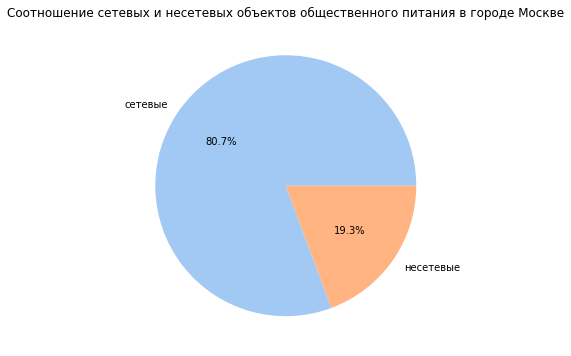

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(rest_data['chain'].value_counts().reset_index()['chain'], labels={'несетевые', 'сетевые'}, autopct='%1.1f%%')
plt.title('Соотношение сетевых и несетевых объектов общественного питания в городе Москве')
plt.show()

Диаграммы показывают, что подавляющее большинство объектов общественного питания - более 80% - несетевые.

Проанализируем, для каких видов заведений характерно сетевое распространение. Для этого посчитаем количество сетевых заведений по каждому виду и выведем долю сетевых объектов в общем количестве.

In [10]:
rest_data_chain_pivot = (rest_data.pivot_table(
                                 values='id',
                                 index='object_type',
                                 columns='chain',
                                 aggfunc='count')
                            .reset_index()
                            .rename(columns={'да': 'chain_qty', 'нет': 'total_qty'})
                  )
rest_data_chain_pivot['total_qty'] = rest_data_chain_pivot['chain_qty'] + rest_data_chain_pivot['total_qty']
rest_data_chain_pivot['chain_part'] = round(rest_data_chain_pivot['chain_qty'] / rest_data_chain_pivot['total_qty'], 3)
rest_data_chain_pivot.sort_values(by='chain_part', ascending=False).rename(columns={'object_type': 'Тип объекта общественного питания', 'chain_qty': 'Количество сетевых объектов', 'total_qty': 'Общее количество объектов', 'chain_part': 'Доля сетевых объектов'})

chain,Тип объекта общественного питания,Количество сетевых объектов,Общее количество объектов,Доля сетевых объектов
6,предприятие быстрого обслуживания,791,1923,0.411
5,магазин (отдел кулинарии),78,273,0.286
7,ресторан,544,2285,0.238
3,кафе,1396,6099,0.229
2,закусочная,56,360,0.156
4,кафетерий,52,398,0.131
0,бар,37,856,0.043
1,буфет,11,585,0.019
8,столовая,3,2587,0.001


Самая большая доля сетевых объектов общественного питания наблюдается в предприятиях быстрого обслуживания - более 40%. Для этих заведений наиболее характерно сетевое распространение. А вот среди столовых, наоборот, почти нет сетевых заведений.

Проанализируем сетевые заведения и посмотрим, как зависят между собой количество заведений в сети и число посадочных мест. Выясним, что для них характерно: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест.

Сохраним сетевые заведения в отдельный датафрейм и выведем все уникальные значения столбца 'object_name'.

In [11]:
rest_data_chain = rest_data[rest_data['chain'] == 'да']
rest_data_chain['object_name'].unique()

array(['ПИЦЦЕТОРИЯ', 'Брусника', 'Алло Пицца', 'Суши Wok', 'Тануки',
       "Домино'с Пицца", 'Готика', 'Му-Му', 'Хлеб насущный', 'TAJJ MAHAL',
       'ДАНКИН ДОНАТС', 'Вареничная №1', 'ШОКОЛАДНИЦА', 'Теремок',
       'Хинкальная', 'Шантимель', 'ТАНУКИ', 'Шоколадница', 'МУ-МУ',
       'Хинкальная City', 'КРУЖКА', 'СУШИ ВОК', 'ПРИМАВЕРА', 'Виктория',
       'Пиццерия «АКАДЕМИЯ»', 'Чебуречная СССР', 'МАКДОНАЛДС',
       'Grand Cru', 'Чайхона №1', 'Панчо Пицца', 'KFC', 'Сабвей',
       'ресторан «Якитория»', 'Советские времена', 'Кафе «Андерсон»',
       'Кафе «Subway»', 'Ресторан «Макдоналдс»', 'Суши Сет', 'Суши WoK',
       'Шоколад', 'Тирольские пироги', 'Гамбринус', 'Пицца Фабрика',
       'Subway', 'Кафе «Якитория»', 'Кафе «Тануки»', 'Сити Пицца',
       'Кружка', 'Кофе Хаус',
       'Кулинарная Лавка Братьев Караваевых Братья Караваевы', 'Суши Вок',
       'Прайм', 'Пицца Экспресс', 'Шоколадница Кофе Хаус', 'Николай',
       'Якитория', 'МАГНОЛИЯ', 'КОФЕ С СОБОЙ', 'Джаганнат', 'Волк

Видим, что одна и та же сеть заведений может быть записана по-разному (например, "Макдоналдс", "Ресторан «Макдоналдс»" и "МАКДОНАЛДС" - это одна сеть, но алгоритмом из-за неодинакового написания она будет распознаваться как несколько разных). Уберём из названий сетевых заведений кавычки, типы заведений, приведём все названия к нижнему регистру и к единообразному написанию.

In [12]:
rest_data_chain['object_name'] = rest_data_chain['object_name'].str.lower()

list_of_words = ['закусочная ', 'магазин готовой еды ', '«', '»', '.', 'кафе ', 'кофейня ', 'детское ', 'кондитерская ', 'пиццерия ', 'предприятие быстрого обслуживания ', 'ресторан ', ' и ', 'семейный ', 'семейное ', 'пекарня ', 'точка продажи готовой еды ', 'быстрого питания ', 'японской кухни ', 'кафе-пекарея ', 'сеть городских кафе', 'кальян- бар ', 'кальян-бар ', 'кальянная ', 'мороженного ', 'кондитерская-пекарня ', 'лаундж-бар ', 'москва - ', ' на шаболовке', 'магазин-кулинария ', ' автозаводская', ' азс №17', 'боулинг-', ' октябрьская', ' шаболовка', 'пбо ', ' покрышкина', 'бар- буфет ', 'бар-буфет ', 'бар ', 'предприятие быстрого питания ', 'быстрого питания ', 'ресторан', 'спорт-бар ', ' спорт бар', 'спорт-', 'ав-дейл', ' 2', '. экспрессо капучино бар', '-центрнефтьпродукт', ' азс №16', 'предприятие ', 'ростикс ', ' (кондитерские)', ' бутово', ' вавилова', 'точка продажготовой еды ', '-инвест', 'сеть магазинов ', 'японский ', ' инвест', 'анти-', ' пекарня', ' волгоградский', ' frozen yogurt', 'вгост', 'готовые блюда ', 'детский клуб ', 'кондитерия ', 'траттория ', ' цех по изготовлению пиццы', ' ясенево']

for word in list_of_words:
    rest_data_chain['object_name'] = rest_data_chain['object_name'].str.replace(word, '')

def correct_name(str):
    if 'prime' in str:
        return 'prime star'
    elif 'прайм' in str:
        return 'prime star'
    elif 'starbucks' in str:
        return 'starbucks'
    elif 'старбакс' in str:
        return 'starbucks'
    elif 'бургер кинг' in str:
        return 'burger king'
    elif 'burger king' in str:
        return 'burger king'
    elif 'domino' in str:
        return 'dominos'
    elif 'домино' in str:
        return 'dominos'
    elif 'stardog' in str:
        return 'стардогs'
    elif 'стардог' in str:
        return 'стардогs'
    elif 'subway' in str:
        return 'subway'
    elif 'сабвей' in str:
        return 'subway'
    elif 'урюк' in str:
        return 'урюк'
    elif 'волконский' in str:
        return 'волконский'
    elif 'мавлин' in str:
        return 'павлин-мавлин'
    elif 'миллер' in str:
        return 'старина миллер'
    elif 'travelers coffe' in str:
        return 'travelers coffee'
    elif 'караваев' in str:
        return 'братья караваевы'
    elif 'вьеткафе' in str:
        return 'вьеткафе'
    elif 'папа джонс' in str:
        return 'папа джонс'
    elif 'krispy' in str:
        return 'krispy creme'
    elif 'в&в' in str:
        return 'в&в бургер'
    elif 'шантимель' in str:
        return 'шантимель'
    elif 'ванвок' in str:
        return 'ванвок'
    elif 'маки-маки' in str:
        return 'маки-маки'
    elif 'maki maki' in str:
        return 'маки-маки'
    elif 'маки маки' in str:
        return 'маки-маки'
    elif 'иль патио' in str:
        return 'иль патио'
    elif 'иль-патио' in str:
        return 'иль патио'
    elif 'празс' in str:
        return 'празс'
    elif 'pomodoro' in str:
        return 'pomodoro'
    elif 'икеа' in str:
        return 'икеа'
    elif 'wokker' in str:
        return 'wokker'
    elif 'воккер' in str:
        return 'wokker'
    elif 'кофе хау' in str:
        return 'кофе хаус'
    elif 'кофе-хаус' in str:
        return 'кофе хаус'
    elif 'иль форно' in str:
        return 'иль форно'
    elif 'кулинарное бюро' in str:
        return 'кулинарное бюро kitchen'
    elif 'гудман' in str:
        return 'стейк хаус гудман'
    elif 'штолле' in str:
        return 'штолле'
    elif 'штолле' in str:
        return 'штолле'
    elif 'пиппони' in str:
        return 'пицца пипони'
    elif 'барбарис' in str:
        return 'барбарис'
    elif 'чайхона №1' in str:
        return 'чайхона №1'
    elif 'upside down' in str:
        return 'upside down'
    elif 'коста кофе' in str:
        return 'costa coffee'
    elif 'coffeeshop' in str:
        return 'coffeeshop'
    elif 'пронто' in str:
        return 'пронто'
    elif 'мята' in str:
        return 'мята lounge'
    elif 'кружка' in str:
        return 'кружка'
    elif 'мимино' in str:
        return 'мимино'
    elif 'ситпицца' in str:
        return 'ситпицца'
    else:
        return str

rest_data_chain['object_name'] = rest_data_chain['object_name'].apply(correct_name)

Теперь сгруппируем датафрейм по имени заведения, и посчитаем количество заведений в сети и медианное значение числа посадочных мест. Выведем на экран 15 заведений с наибольшим количеством объектов в сети.

In [13]:
rest_data_chain = (rest_data_chain
                             .groupby(['object_name'])
                             .agg({'id': 'count', 'number': 'median'})
                             .reset_index()
                             .rename(columns={'id': 'count', 'number': 'number_median'})
                  )
(rest_data_chain
     .sort_values(by='count', ascending=False)
     .rename(columns={'object_name': 'Название сети объектов общественного питания', 'count': 'Количество объектов в сети', 'number_median': 'Медианное количество посадочных мест'})
     .head(15))

,Название сети объектов общественного питания,Количество объектов в сети,Медианное количество посадочных мест
23,kfc,187,48.0
284,шоколадница,183,50.0
162,макдоналдс,173,76.0
7,burger king,159,45.0
250,теремок,111,24.0
13,dominos,99,16.0
153,крошка картошка,96,15.0
172,милти,81,0.0
236,суши wok,76,6.0
39,starbucks,71,40.0


Построим график зависимости числа объектов общественного питания в сети и медианного количества посадочных мест:

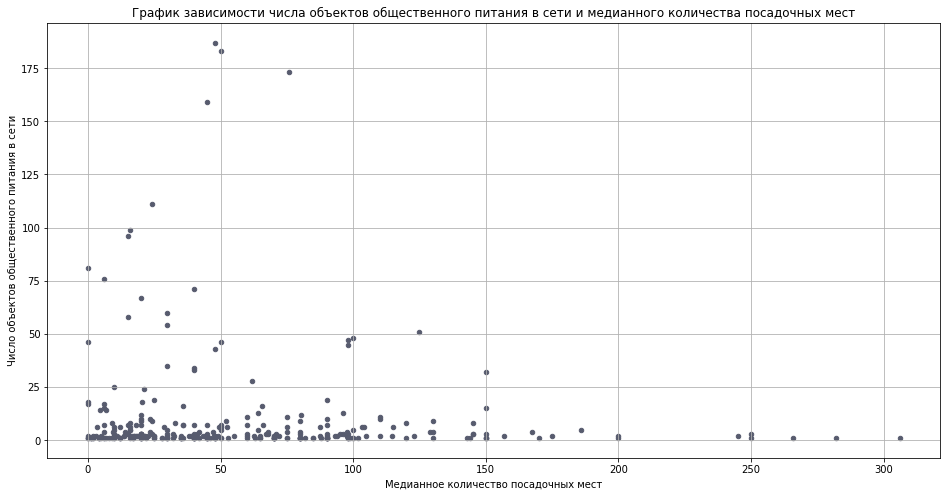

In [14]:
rest_data_chain.plot(x='number_median', y='count', kind='scatter', figsize=(16, 8), color='#575b6e', grid=True)
plt.title('График зависимости числа объектов общественного питания в сети и медианного количества посадочных мест')
plt.xlabel('Медианное количество посадочных мест')
plt.ylabel('Число объектов общественного питания в сети')
plt.show()

Укрупним нижнюю часть графика:

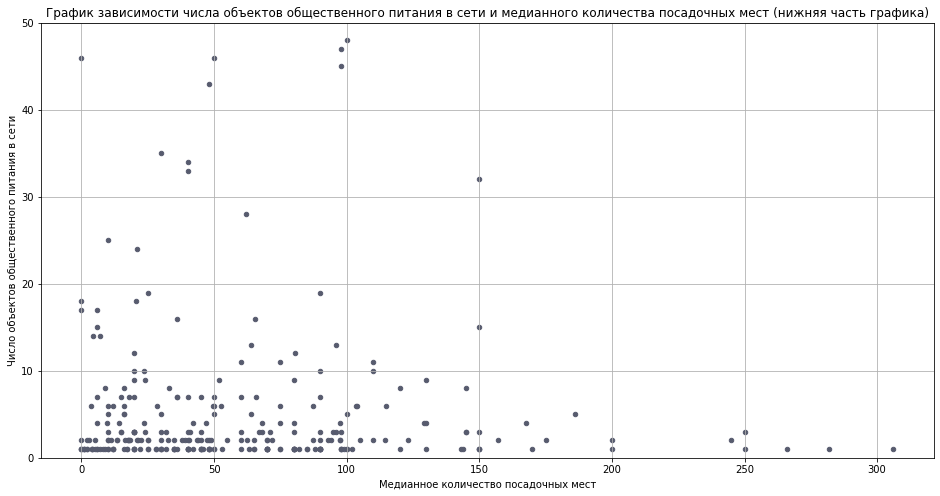

In [15]:
rest_data_chain.plot(x='number_median', y='count', kind='scatter', figsize=(16, 8), color='#575b6e', grid=True)
plt.title('График зависимости числа объектов общественного питания в сети и медианного количества посадочных мест (нижняя часть графика)')
plt.xlabel('Медианное количество посадочных мест')
plt.ylabel('Число объектов общественного питания в сети')
plt.ylim(0, 50)
plt.show()

По графику видно, что для сетевых заведений характерно небольшое количество объектов в сети (до 20) с количеством посадочных мест в диапазоне от 0 до 100.

Посчитаем среднее количество посадочных мест для каждого вида объекта общественного питания.

In [16]:
rest_data_number = (rest_data
     .groupby(['object_type'])
     .agg({'number': 'mean'})
     .sort_values(by='number', ascending=False)
     .reset_index()
     )


rest_data_number['number'] = rest_data_number['number'].round(decimals=1)

(rest_data_number
        .rename(columns={'object_type': 'Вид объектов общественного питания', 'number': 'Среднее количество посадочных мест'})
)

,Вид объектов общественного питания,Среднее количество посадочных мест
0,столовая,130.2
1,ресторан,96.8
2,буфет,51.1
3,бар,43.5
4,кафе,39.7
5,предприятие быстрого обслуживания,20.6
6,кафетерий,9.1
7,закусочная,7.6
8,магазин (отдел кулинарии),5.6


Построим столбчатую диаграмму, чтобы визуализировать среднее количество посадочных мест для каждого вида объекта общественного питания.

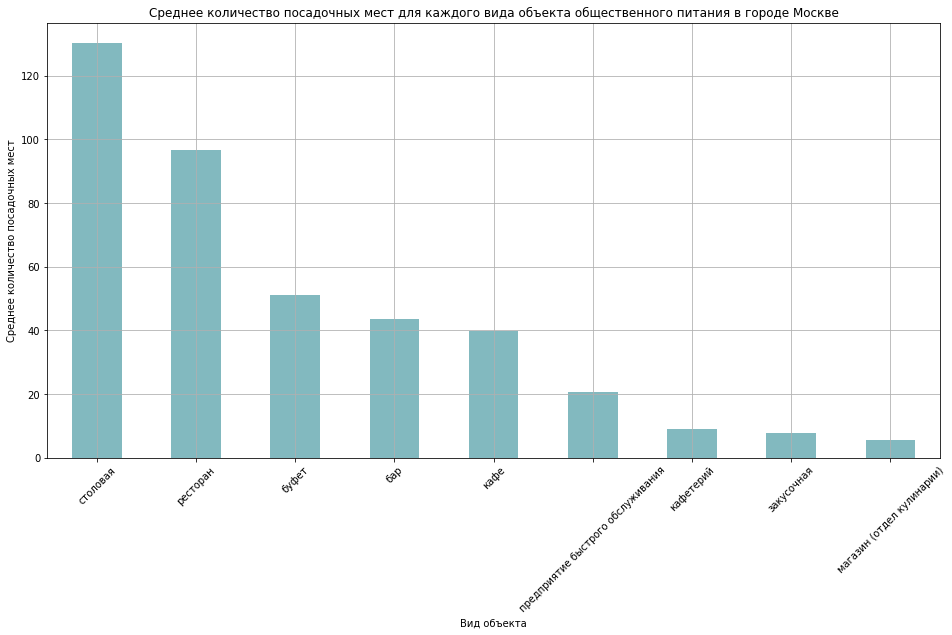

In [17]:
ax = rest_data_number['number'].plot(kind='bar', figsize=(16, 8), grid=True, color='#82b9bf', legend=None)
ax.set_title('Среднее количество посадочных мест для каждого вида объекта общественного питания в городе Москве')
ax.set_xlabel('Вид объекта')
ax.set_ylabel('Среднее количество посадочных мест')
ax.set_xticklabels(rest_data_number['object_type'], rotation=45)
plt.show()

В среднем самое большое количество посадочных мест предоставляют столовые и рестораны. У буфетов посадочных мест в среднем почти в два раза меньше, чем у ресторанов. У баров и кафе мест уже примерно в 3 раза меньше, чем у столовых, а у предприятий быстрого обслуживания - в 2 раза меньше, чем у кафе. Самое маленькое количество мест в среднем предоставляют такие типы заведений, как кафетерии, закусочные и отделы кулинарии в магазинах.

### Исследование местоположения объектов общественного питания

Выделим в отдельный столбец 'street' информацию об улице из столбца 'address'. Зададим список с типами улиц, включив туда также некоторые названия населённых территорий, где нет улиц. Затем зададим функцию, которая выделяет из адреса название улицы.

In [18]:
street_names = [
    'переулок',
    'проспект',
    'шоссе',
    'бульвар',
    'проезд',
    'улица',
    'набережная',
    'площадь',
    'вал',
    'аллея',
    'линия',
    'квартал',
    'микрорайон',
    'тупик',
    'территория',
    'просек',
    'мост',
    'парк',
    'Зеленоград',
    'деревня',
    'посёлок',
    'поселок',
    'село',
    'километр Московской Кольцевой',
    'километр МКАД',
    'Щаповское',
    'Марушкинское',
    'Вороновское'
]

def get_street(address):
    entries = re.split(',', address)
    for entry in entries:
        for name in street_names:
            if name in entry:
                return entry

# применяем функцию
rest_data['street'] = rest_data['address'].apply(get_street)

# убираем пробелы слева и справа
rest_data['street'] = rest_data['street'].str.strip()

rest_data

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица
...,...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское шоссе, 22-й километр, домовладение 4, строение 1",36,Киевское шоссе


Проверим, нет ли в новом столбце пропущенных значений:

In [19]:
print('Количество пропущенных значений в столбце "street":', len(rest_data[rest_data['street'].isna() == True]))

Количество пропущенных значений в столбце "street": 1


В таблице остался всего один пропуск. Выведем на экран строку с пропущенным значением:

In [20]:
rest_data[rest_data['street'].isna() == True]

,id,object_name,chain,object_type,address,number,street
14807,214436,КАФЕ,нет,буфет,"город Москва, поселение ""Мосрентген"", МКАД, 44-й километр, владение 1, строение 1",36,None


Заполним единственный оставшийся пропуск вручную.

In [21]:
rest_data['street'] = rest_data['street'].fillna('МКАД, 44-й километр')
print('Количество пропущенных значений в столбце "street":', len(rest_data[rest_data['street'].isna() == True]))

Количество пропущенных значений в столбце "street": 0


Воспользуемся внешней информацией - таблицей соответствия улиц и районов города area_data, и добавим в таблицу rest_data информацию о районе города, к которому принадлежат объекты общественного питания. Выведем десять произвольных строк этой таблицы для ознакомления.

In [22]:
spreadsheet_id = '1wTkL0BWDCchtSgFsciRMuQWDJxmcnzXqoauclrQHfUo'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
area_data = pd.read_csv(BytesIO(r.content))
area_data = area_data.rename(columns={'streetname': 'street'}).drop(columns=['areaid', 'okrug'])
area_data.sample(n=10, random_state=1)

,street,area
3015,Липецкая улица,Район Бирюлево Восточное
1073,улица 9 Мая,Район Восточный
993,улица Измайловский Вал,Район Соколиная Гора
3116,Балаклавский проспект,Район Чертаново Северное
3599,улица Знаменка,Район Хамовники
2801,Московская Кольцевая Автодорога,Район Митино
2579,Мурманский проезд,Останкинский район
3079,улица Бехтерева,Район Царицыно
4423,улица Сервантеса,поселение Сосенское
779,Большая Косинская улица,Район Косино-Ухтомский


Так как одной улице в таблице может соответствовать несколько районов, сгруппируем таблицу по названиям улиц и сложим районы, соответствующие улицам, в список.

In [23]:
area_data = area_data.groupby(['street']).agg({'area': 'unique'}).reset_index()
area_data

,street,area
0,1-й Автозаводский проезд,[Даниловский район]
1,1-й Амбулаторный проезд,[Район Аэропорт]
2,1-й Архивный переулок,[Район Хамовники]
3,1-й Бабьегородский переулок,[Район Якиманка]
4,1-й Балтийский переулок,[Район Аэропорт]
...,...,...
3739,улица Юности,"[Район Вешняки, Район Матушкино-Савелки]"
3740,улица Юных Ленинцев,"[Район Кузьминки, Район Текстильщики]"
3741,улица Яблочкова,[Бутырский район]
3742,шоссе Фрезер,[Нижегородский район]


Добавим к основной таблице rest_data столбец с районом методом `.merge()`. Проверим, есть ли пропуски в новом столбце.

In [24]:
rest_data_area = rest_data.merge(area_data, on = ['street'], how='left')
print('Количество пропущенных значений в столбце "area":', len(rest_data_area[rest_data_area['area'].isna() == True]))

Количество пропущенных значений в столбце "area": 39


Выведем на экран строки с отстуствующими значениями в столбце 'area':

In [25]:
rest_data_area[rest_data_area['area'].isna() == True]

,id,object_name,chain,object_type,address,number,street,area
1737,69842,Чайхона №1,да,ресторан,"город Москва, улица Мичуринский Проспект, Олимпийская Деревня, дом 1, корпус 1",94,улица Мичуринский Проспект,NaN
2942,19643,Бар «ЛЮКС»,нет,бар,"город Москва, улица Мичуринский Проспект, Олимпийская Деревня, дом 4, корпус 1",24,улица Мичуринский Проспект,NaN
2943,19978,Ресторан «Люкс»,нет,ресторан,"город Москва, улица Мичуринский Проспект, Олимпийская Деревня, дом 4, корпус 1",100,улица Мичуринский Проспект,NaN
2944,23451,СТОЛОВАЯ при «ЛЮКС»,нет,столовая,"город Москва, улица Мичуринский Проспект, Олимпийская Деревня, дом 4, корпус 1",66,улица Мичуринский Проспект,NaN
3134,69195,МАКДОНАЛДС,да,предприятие быстрого обслуживания,"город Москва, улица Героев-Панфиловцев, дом 7",114,улица Героев-Панфиловцев,NaN
3135,127544,Пиццерия Хвост Бобра,нет,кафе,"город Москва, улица Героев-Панфиловцев, дом 7",10,улица Героев-Панфиловцев,NaN
3485,79548,Ресторан «Florentini»,да,ресторан,"город Москва, улица Мичуринский Проспект, Олимпийская Деревня, дом 4, корпус 3",95,улица Мичуринский Проспект,NaN
3490,22942,ПАБ Zolden (закрыто на ремонт в 2018 году),нет,ресторан,"город Москва, улица Мичуринский Проспект, Олимпийская Деревня, дом 3",150,улица Мичуринский Проспект,NaN
6434,23577,СТОЛОВАЯ ШКОЛА 843 (812),нет,столовая,"город Москва, улица Мичуринский Проспект, Олимпийская Деревня, владение 22А",150,улица Мичуринский Проспект,NaN
6448,129686,Три правила,нет,кафе,"город Москва, улица Мичуринский Проспект, Олимпийская Деревня, дом 3, корпус 1",70,улица Мичуринский Проспект,NaN


Пропуски возникли скорее всего из-за различий в написании улиц. В таблице соответствия улиц и районов "Мичуринский проспект" наверняка записан без слова "улица" перед ним. А "улица Героев-Панфиловцев" правильно пишется без дефиса - "улица Героев Панфиловцев". Проверим наши предположения:

In [26]:
area_data[area_data['street'] == 'Мичуринский проспект']

,street,area
1822,Мичуринский проспект,"[Район Очаково-Матвеевское, Район Проспект Вернадского, Район Раменки, Район Тропарево-Никулино]"


In [27]:
area_data[area_data['street'] == 'улица Героев Панфиловцев']

,street,area
3268,улица Героев Панфиловцев,[Район Северное Тушино]


Предположения подтвердились. Откорректируем название улиц и заполним пропуски вручную.

In [28]:
# корректировка названий улиц
rest_data_area.loc[rest_data_area['street'] == 'улица Мичуринский Проспект', ['street']] = 'Мичуринский проспект'
rest_data_area.loc[rest_data_area['street'] == 'улица Героев-Панфиловцев', ['street']] = 'улица Героев Панфиловцев'

# заполнение пропусков
rest_data_area.loc[rest_data_area['street'] == 'Мичуринский проспект','area'] = rest_data_area.loc[rest_data_area['street'] == 'Мичуринский проспект','area'].fillna('[Район Очаково-Матвеевское, Район Проспект Вернадского, Район Раменки, Район Тропарево-Никулино]')
rest_data_area.loc[rest_data_area['street'] == 'улица Героев Панфиловцев','area'] = rest_data_area.loc[rest_data_area['street'] == 'улица Героев Панфиловцев','area'].fillna('[Район Северное Тушино]')

# проверка на наличие пропусков
print('Количество пропущенных значений в столбце "area":', len(rest_data_area[rest_data_area['area'].isna() == True]))

Количество пропущенных значений в столбце "area": 0


Выделим топ-10 улиц по количеству объектов общественного питания и найдем районы, в которых эти улицы расположены. Построим график.

In [29]:
rest_street_top10 = (rest_data_area
                         .groupby(['street'])
                         .agg({'id': 'count'})
                         .reset_index()
                         .sort_values(by='id', ascending=False)
                         .rename(columns={'id': 'rest_qty'})
                         .head(10))

rest_street_top10 = rest_street_top10.merge(area_data, on = ['street'], how='left')
rest_street_top10

,street,rest_qty,area
0,город Зеленоград,232,"[Район Крюково, Район Матушкино-Савелки, Панфиловский район]"
1,проспект Мира,204,"[Алексеевский район, Ярославский Район, Район Марьина роща, Останкинский район, Район Ростокино, Район Свиблово, Мещанский район]"
2,Профсоюзная улица,183,"[Академический район, Район Черемушки, Район Ясенево, Район Коньково, Обручевский район, Район Теплый Стан]"
3,Ленинградский проспект,173,"[Район Аэропорт, Район Беговой, Хорошевский район, Район Сокол]"
4,Пресненская набережная,167,[Пресненский район]
5,Варшавское шоссе,165,"[Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное, Донской район, Район Нагатино-Садовники, Нагорный район, Район Северное Бутово, Район Южное Бутово]"
6,Ленинский проспект,148,"[Район Проспект Вернадского, Район Тропарево-Никулино, Донской район, Район Гагаринский, Ломоносовский район, Обручевский район, Район Теплый Стан, Район Якиманка]"
7,проспект Вернадского,132,"[Район Проспект Вернадского, Район Раменки, Район Тропарево-Никулино, Район Гагаринский, Ломоносовский район]"
8,Кутузовский проспект,114,"[Район Дорогомилово, Район Фили-Давыдково]"
9,Каширское шоссе,112,"[Район Москворечье-Сабурово, Район Нагатино-Садовники, Район Орехово-Борисово Южное, Район Орехово-Борисово Северное]"


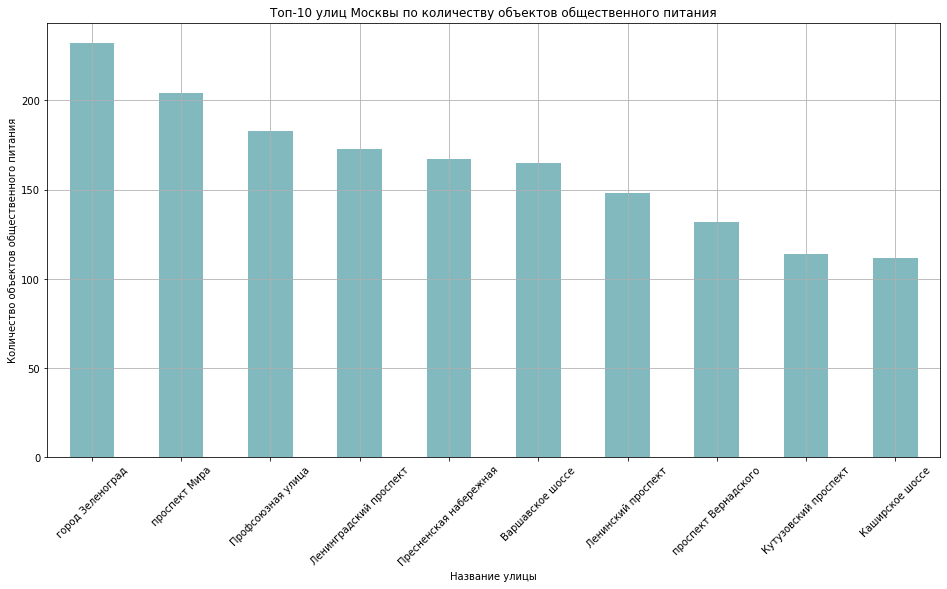

In [30]:
ax = rest_street_top10['rest_qty'].plot(kind='bar', figsize=(16, 8), grid=True, color='#82b9bf', legend=None)
ax.set_title('Топ-10 улиц Москвы по количеству объектов общественного питания')
ax.set_xlabel('Название улицы')
ax.set_ylabel('Количество объектов общественного питания')
ax.set_xticklabels(rest_street_top10['street'], rotation=45)
plt.show()

Мы получили список достаточно протяженных улиц Москвы, расположенных в различных районах города, на которых располагается несколько торговых центров. Пресненская набережная, хотя и непротяженная улица, но насчитывает 4 торговых центра. В торговых центрах присутствует, как правило, большое количество объектов общественного питания - не только в рамках фудкортов, но и в формате отдельных заведений. Этим можно объяснить, почему на этих улицах находится много кафе/ресторанов. 
К аналогичным выводам приводит нас рассмотрение города Зеленограда.

Найдём улицы с одним объектом общественного питания, а также районы расположения этих улиц. Посчитаем их количество.

In [31]:
rest_street_1 = (rest_data_area
                         .groupby(['street'])
                         .agg({'id': 'count'})
                         .reset_index()
                         .rename(columns={'id': 'rest_qty'})
                         )

rest_street_1 = rest_street_1[rest_street_1['rest_qty'] == 1]
rest_street_1 = rest_street_1.merge(area_data, on = ['street'], how='left')
rest_street_1.sample(n=25, random_state=1)

,street,rest_qty,area
261,Малая Андроньевская улица,1,[Таганский район]
548,улица Павла Андреева,1,"[Район Замоскворечье, Даниловский район]"
267,Малый Ивановский переулок,1,[Басманный район]
373,Средний Кондратьевский переулок,1,[Пресненский район]
417,Фруктовая улица,1,"[Нагорный район, Район Зюзино]"
285,Миллионная улица,1,[Район Богородское]
241,Красноказарменный проезд,1,[Район Лефортово]
549,улица Паперника,1,[Рязанский район]
257,Лыщиков переулок,1,[Таганский район]
411,Фармацевтический проезд,1,[Район Коптево]


In [32]:
print('Число улиц с одним объектом общественного питания:', len(rest_street_1))

Число улиц с одним объектом общественного питания: 577


Всего в городе Москве 577 улиц с одним заведением. И здесь опять не наблюдается привязки к какому-то одному округу города - такие улицы могут быть расположены как в центре Москвы, так и ближе к её окраинам. Наличие на этих улицах всего одного объекта общественного питания, может объясняться малой протяжённостью улицы (характерно для небольших проездов, переулков в центре), либо расположением заведений в непопулярном месте (например, промзоны, трассы, МКАД).

Для улиц с большим количеством объектов общественного питания построим распределение количества посадочных мест.

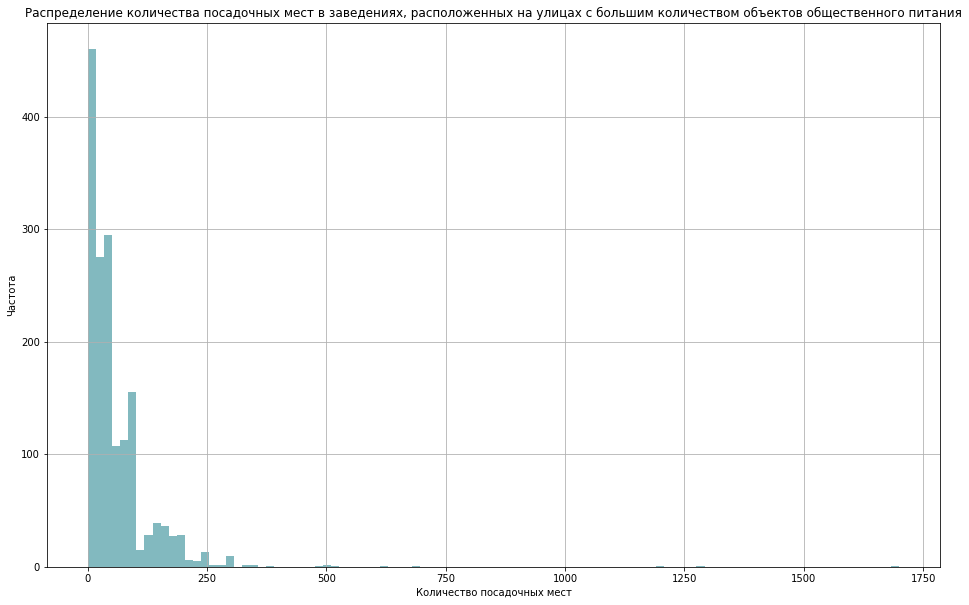

In [33]:
ax = rest_data_area[rest_data_area['street'].isin(rest_street_top10['street'])]['number'].hist(figsize=(16, 10), grid=True, color='#82b9bf', bins = 100)
ax.set_title('Распределение количества посадочных мест в заведениях, расположенных на улицах с большим количеством объектов общественного питания')
ax.set_xlabel('Количество посадочных мест')
ax.set_ylabel('Частота')
plt.show()

Выведем на экран числовое описания серии количества посадочных мест для улиц с большим количеством объектов общественного питания.

In [34]:
rest_data_area[rest_data_area['street'].isin(rest_street_top10['street'])]['number'].describe()

count    1630.000000
mean       60.052147
std        88.024846
min         0.000000
25%        15.000000
50%        40.000000
75%        80.000000
max      1700.000000
Name: number, dtype: float64

На графике распределения виден большой пик около нуля - это означает, что довольно много заведений не имеют посадочных мест. Это могут быть, например, заведения в торговых центрах, где находятся много кафе/ресторанов, для которых обычно есть лишь общая зона с посадочными местами (то есть своих посадочных мест они не имеют). Половина всех заведений имеет до 40 посадочных мест, а основная часть заведений - от 0 до примерно 100 мест.

**Вывод**

В ходе анализа рынка заведений общественного питания города Москвы были выявлены следующие закономерности:
- около 40% всех заведений имеют тип "кафе", а к ресторанам относятся 15% заведений;
- 80% всех заведений не являются сетевыми;
- сетевой тип распространён прежде всего среди предприятий быстрого питания - их доля составляет более 40%. Среди ресторанов и кафе доля сетевых объектов равна 24% и 23% соответственно;
- для сетевых заведений характерно небольшое количество объектов в сети (до 20) с количеством посадочных мест от 0 до 100;
- самое большое количество посадочных мест характерно для столовых (в среднем 130 мест) и ресторанов (в среднем 97 мест); в среднем кафе располагается 40 посадочных мест;
- наибольшее число объектов общественного питания расположено на протяжённых улицах с расположенными на них несколькими торговыми центрами. Районы расположения таких улиц довольно разнообразны, они могут находится как в центре города, так и ближе к окраинам;
- основная часть заведений, расположенных на улицах с большим количеством объектов общественного питания, имеет от 0 до 100 посадочных мест;
- на 577 улицах Москвы располагается лишь по одному заведению. Объясняется это может либо маленькой протяжённостью улицы, либо непопулярностью (низкой проходимостью) места расположения.

## Выводы

На основании открытых данных об объектах общественного питания был проведён анализ рынка заведений города Москвы. Выявленные в процессе анализа закономерности, подробно отраженные в выводе к предыдущему пункту, помогли нам сделать обоснованные предложения о виде заведения, количестве посадочных мест, районе расположения, а также о возможности развития сети:
- Так как планируется открытие заведения с роботами-официантами, мы не будем рассматривать в качестве потенциальных такие типы заведений, как столовая, бар, буфет, кафетерий, закусочная и предприятие быстрого питания, поскольку такие типы заведений, как правило, не предполагают наличие официантов. Остановимся на выборе из двух вариантов: ресторан или кафе. Как мы увидели, самый распространёный тип заведения, на долю которого приходится 40% всех заведений в городе, - это кафе. Такая массовая распространённость кафе делает этот тип заведения в сознании потребителей доступным. Однако в пользу варианта "ресторан" говорит относительно небольшая доля ресторанов на рынке - 15%. Поэтому оба варианта - ресторан и кафе - являются потенциально возможными;
- Рестораны - вторые в рейтинге заведений с наибольшим количеством посадочных мест - в среднем ресторане - 97 мест. Среднее кафе имеет 40 мест. Для заведений, расположенных на улицах с большим количеством объектов общественного питания характерно до 100 мест. Следовательно, можно порекомендовать 50-100 посадочных мест для нашего заведения.
- Исследование местоположения показало, что есть улицы с очень большим расположенным на них количеством заведений, так и улицы с одним объектом общественного питания. Районы расположения как первых, так и вторых, достаточно разнообразны, они могут лежать и в центре города, и ближе к окраине. С одной стороны кажется, что на улицах с одним заведением меньше конкуренции, и что там стоит открывать наше кафе, однако малое количество заведений на улице может говорить о низкой проходимости. На улицах с большим количеством объектов общественного питания, наоборот, проходимость очень высокая, и такие улицы могут быть потенциально более привлекательны. Одновременно при выборе местоположения следует отталкиваться от формата нашего заведения и от местанахождения целевой аудитории. Поскольку у нас заведение очень нетипичное, оно способно стать не просто местом для принятия пищи, но и некой достопримечательностью, аттракционом. Значит, лучше всего его расположить в районах, часто посещаемых и туристами, и москвичами, то есть в районах, принадлежащих ЦАО. Это поможет не только наработать лояльных посетителей, но и постоянный приток новых клиентов. Таким образом, рекомендованный район для открытия - Пресненский.
- Сетевых заведений в Москве всего 20% от общего числа, а среди ресторанов и кафе доля сетевых составляет 24% и 23% соответственно. Потенциальная возможность для развития сети есть.